In [ ]:
# Some useful links
# ConvLSTM: https://github.com/iamrakesh28/Video-Prediction
# Kaggle guide related to github link above: https://www.kaggle.com/code/kcostya/convlstm-convolutional-lstm-network-tutorial
# Paper about ConvLSTM: https://arxiv.org/pdf/2201.06173

# Multidimensional for Yolo: https://github.com/ultralytics/ultralytics/issues/2154
# https://arxiv.org/html/2409.17363v2#bib.bib4

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error

---

In [ ]:
# Uploading data
dataset = np.load('/content/dataset20250610.npy')
print(dataset.shape)

labels, images = zip(*dataset)
#images = np.array([item[1] for item in dataset])  # shape: (n, 10, 10, 19)
images = np.array(images)
labels = np.array(labels)
print("images.shape:", images.shape)
print("labels.shape:", labels.shape)

# Step 2: Reshape to (n * 10 * 10, 19)
pixels = images.reshape(-1, 19)
print("pixels.shape:", pixels.shape)
print()

(943,)
images.shape: (943, 10, 10, 19)
labels.shape: (943,)
pixels.shape: (94300, 19)



In [ ]:
# Removing images that are completely blank
valid = ~np.all(np.isnan(images).reshape(images.shape[0], -1), axis=1)
print("removing", np.sum(~valid), "images")
images = images[valid]
labels      = labels[valid]

removing 0 images


In [ ]:
# Existing labels
s = set()
for i in dataset:
  s.add(i[0])
print(s)

{np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4)}


(array([409.,   0., 236.,   0.,   0., 137.,   0.,  93.,   0.,  68.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

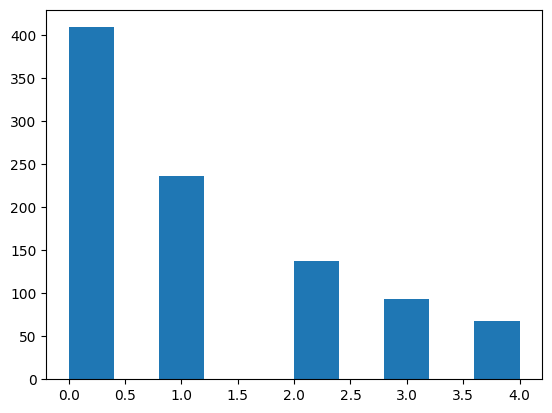

In [ ]:
plt.hist(labels)

0


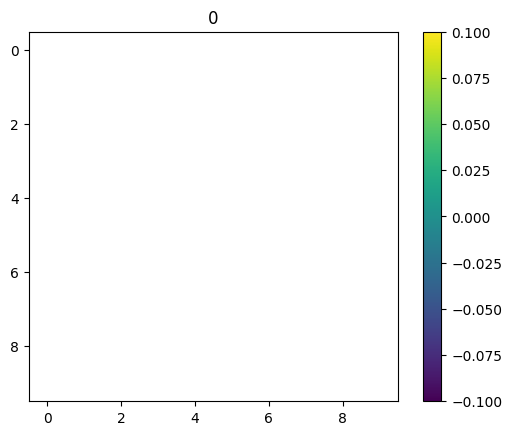

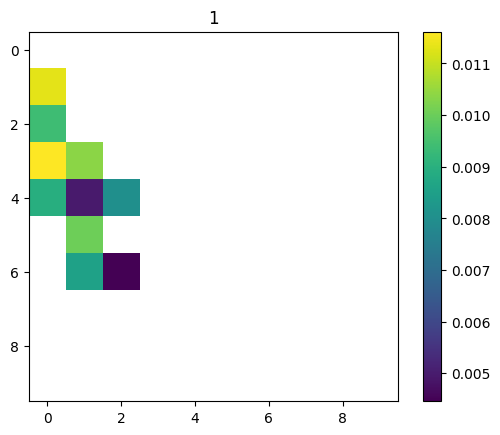

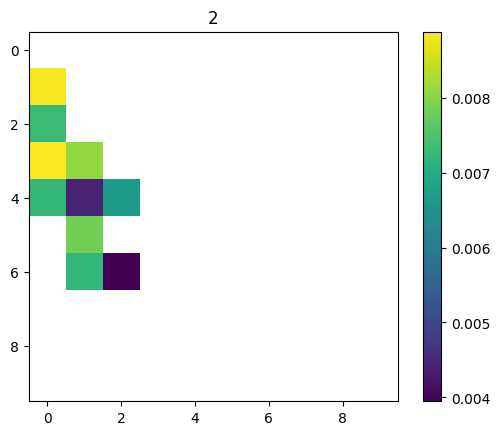

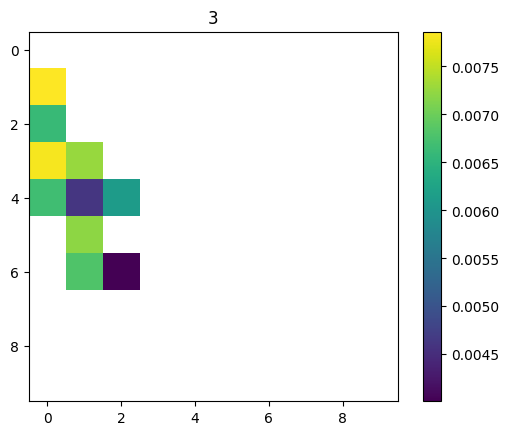

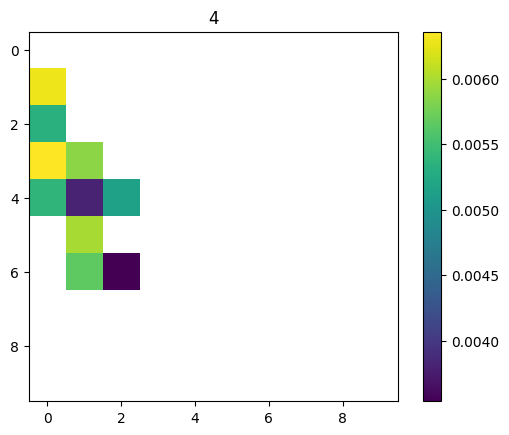

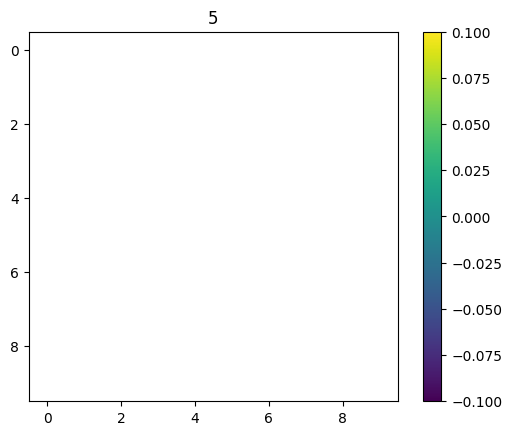

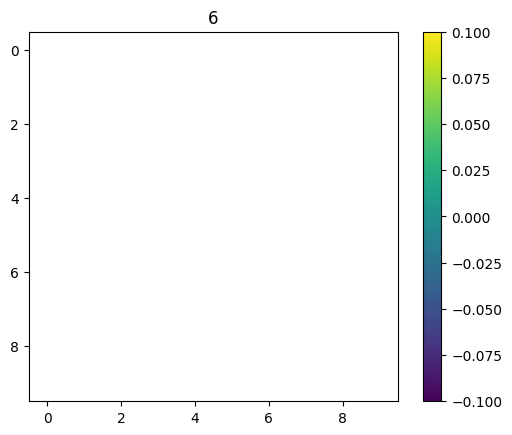

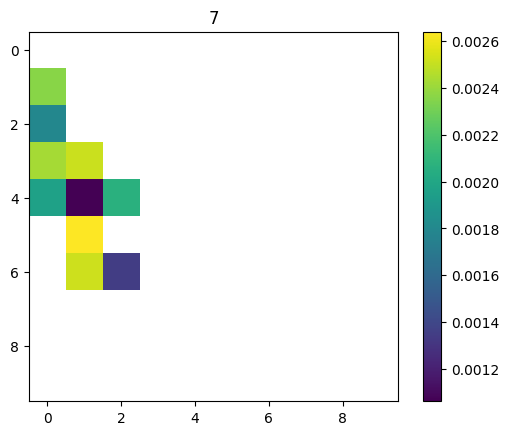

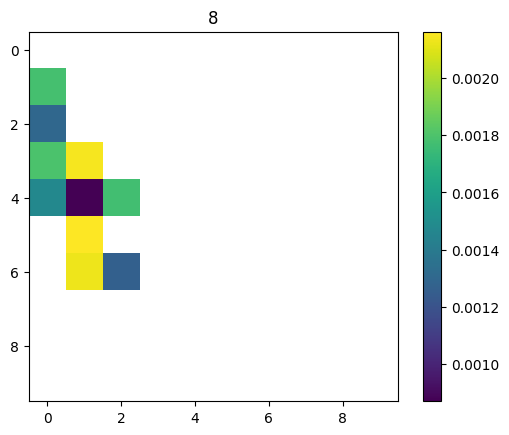

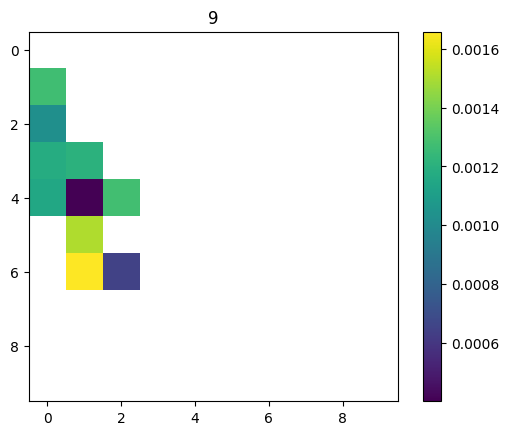

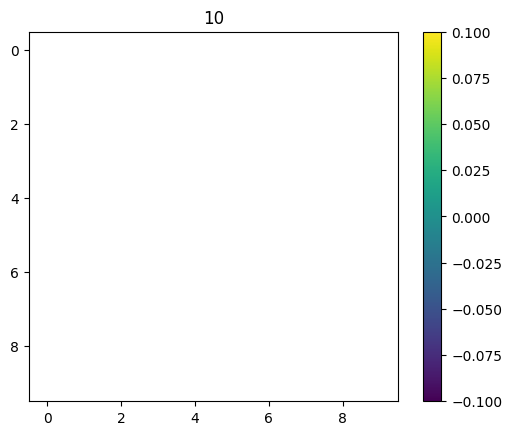

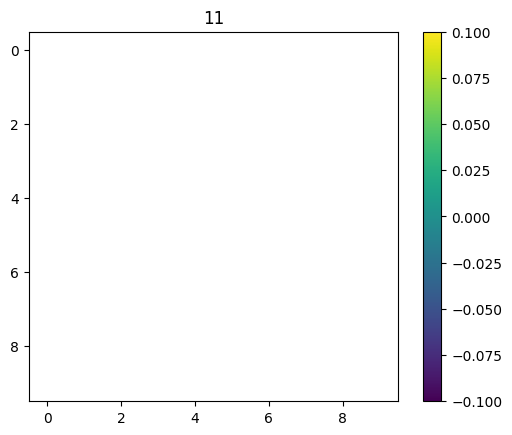

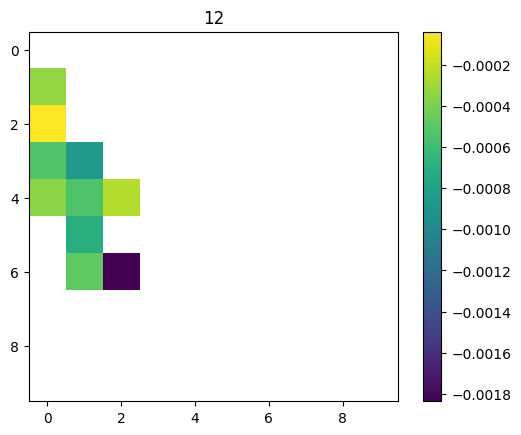

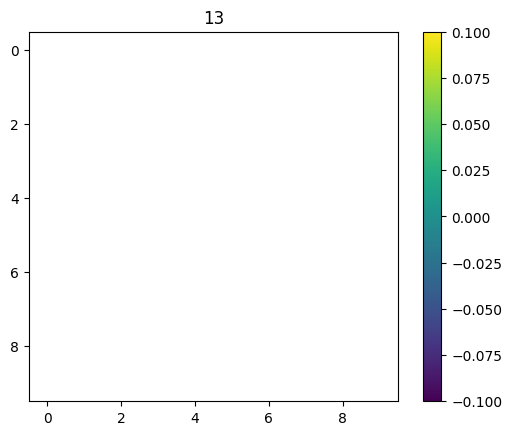

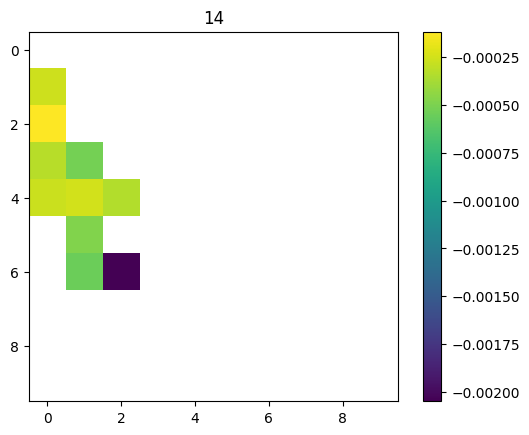

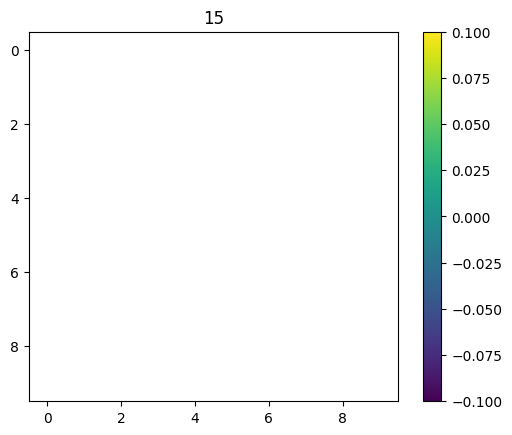

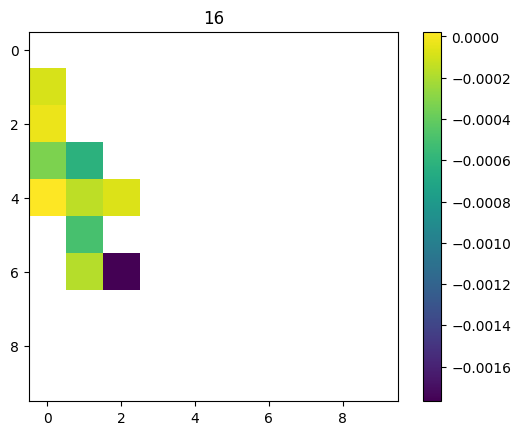

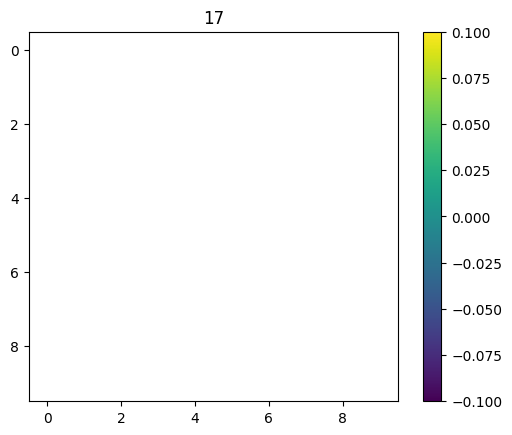

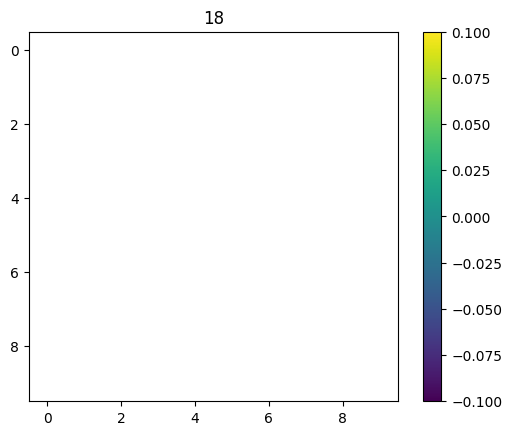

In [ ]:
# Displaying sample of one image split into 19 channels
print(labels[0])
for i in range(19):
  plt.imshow(images[0][:, :, i], cmap='viridis', interpolation='nearest')
  plt.colorbar()
  plt.title(i)
  plt.show()


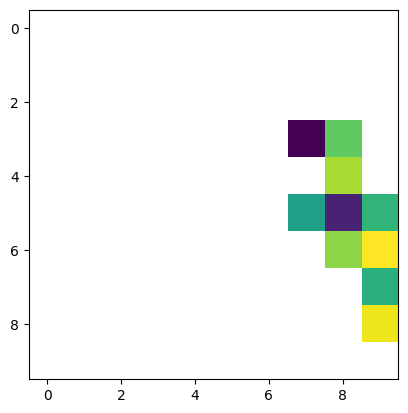

In [ ]:
# Testing image flipping
temp = np.flip(images, axis=2)
temp = np.flip(temp, axis=1)
plt.imshow(temp[0][:, :, 4], cmap='viridis', interpolation='nearest')

In [ ]:
# Ensuring equal class distributions in resulting classes
# Also adds samples via flipping image
prev = 0
# Indices for label splits (from plt.hist(labels) earlier)
next = [409, 236, 137,  93,  68]

labelSize = next[-1] * 4

np.random.seed(0)

x = None
y = np.array([])

for i in next:
  # Data related to certain label
  data = images[prev:prev+i]

  # Flip on y-axis
  flip_y = np.flip(data, axis=2)

  # Flip over X-axis
  flip_x = np.flip(data, axis=1)  # flip along height

  # flip x and y
  flip_xy = np.flip(flip_x, axis=2)

  # Adding flipped images from array to-be-sampled from
  temp = np.concatenate([data, flip_y, flip_x, flip_xy], axis=0)

  # sampling for equal distributions
  index = np.random.choice(len(temp), size=labelSize, replace=False)
  temp = temp[index]

  if x is None:
    x = temp
  else:
    x = np.vstack((x, temp))
  # Could make this step more efficient

  prev += i


x = np.nan_to_num(x, nan=0)
print("Final sample shape:", x.shape)      # (150, 10, 10)

# Can generate final labels like this due to pre-determined order and amount of labels
y = np.repeat([0,1,2,3,4], labelSize)

# One-hot encode labels
y = np.eye(5)[y]
print("Final label shape:", y.shape)

Final sample shape: (1360, 10, 10, 19)
Final label shape: (1360, 5)


(array([0., 0., 0., 0., 0., 5., 0., 0., 0., 0.]),
 array([271.5, 271.6, 271.7, 271.8, 271.9, 272. , 272.1, 272.2, 272.3,
        272.4, 272.5]),
 <BarContainer object of 10 artists>)

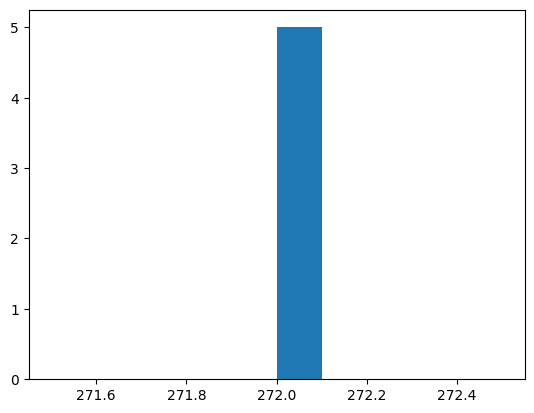

In [ ]:
# Depreciated: checking distributions for y
plt.hist(np.sum(y, axis=0))

In [ ]:
# mask = 1 where any band is non-NaN; 0 where all NaN
mask = np.any(~np.isnan(x), axis=-1, keepdims=True).astype('float32')
# zero-fill the 19 bands
# concatenate mask as 20th channel
temp = np.concatenate([x, mask], axis=-1)  # (N,10,10,20)
print("After mask:", temp.shape)

# Normalizing content of x
means = np.nanmean(temp[..., :19], axis=(0,1,2))
stds  = np.nanstd(temp[..., :19], axis=(0,1,2))
# Broadcast and normalize
x_norm = temp.copy()
x_norm[..., :19] = (temp[..., :19] - means) / (stds + 1e-6)
print(x_norm.shape)

After mask: (1360, 10, 10, 20)
(1360, 10, 10, 20)


In [ ]:
X_temp, X_val, y_temp, y_val = train_test_split(x_norm, y, test_size=1/8, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(x_norm, y, test_size=1/7, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1165, 10, 10, 20) (170, 10, 10, 20) (195, 10, 10, 20)
(1165, 5) (170, 5) (195, 5)


(array([[929.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 236.],
        [930.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 235.],
        [939.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 226.],
        [924.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 241.],
        [938.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 227.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 5 BarContainer objects>)

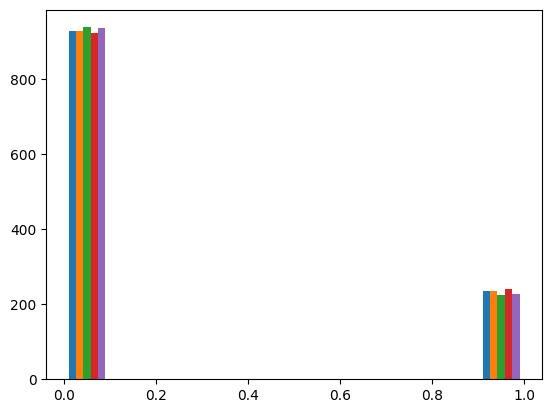

In [ ]:
plt.hist(y_train)

In [ ]:
model = models.Sequential([
    layers.Input(shape=(10,10,20)),

    # Convolution layers
    layers.Conv2D(32, kernel_size=(1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=(1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),

    # Flatten spatial dims into instance dimension
    layers.Reshape((10*10, 64)),          # (batch,100,64)
    # Per-instance embedding

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),

    layers.GlobalMaxPooling1D(),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),


    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(15, activation='relu'),
    layers.Dropout(0.2),

    # Output layer: 5-class sigmoid (want individual possibility for each class)
    layers.Dense(5, activation='sigmoid')
])

# Compile
model.compile(optimizer= optimizers.Adam(learning_rate=0.0008),
              # Each class is binary
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), 'f1_score'])

# Summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 32)     │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 10, 10, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100, 128)       │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 15)             │           495 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │            80 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,655 (88.50 KB)

 Trainable params: 22,335 (87.25 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
#from re import VERBOSE
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=400, batch_size=64,verbose=2)

Epoch 1/400
19/19 - 7s - 388ms/step - accuracy: 0.1923 - auc: 0.4952 - f1_score: 0.1328 - loss: 0.8650 - val_accuracy: 0.2471 - val_auc: 0.5251 - val_f1_score: 0.1461 - val_loss: 0.6788
Epoch 2/400
19/19 - 2s - 109ms/step - accuracy: 0.2189 - auc: 0.5225 - f1_score: 0.1604 - loss: 0.7017 - val_accuracy: 0.3059 - val_auc: 0.5758 - val_f1_score: 0.2061 - val_loss: 0.6495
Epoch 3/400
19/19 - 1s - 50ms/step - accuracy: 0.2120 - auc: 0.5452 - f1_score: 0.1518 - loss: 0.6412 - val_accuracy: 0.3118 - val_auc: 0.5927 - val_f1_score: 0.1945 - val_loss: 0.6142
Epoch 4/400
19/19 - 1s - 59ms/step - accuracy: 0.2378 - auc: 0.5633 - f1_score: 0.1714 - loss: 0.6017 - val_accuracy: 0.3118 - val_auc: 0.5985 - val_f1_score: 0.1822 - val_loss: 0.5893
Epoch 5/400
19/19 - 1s - 66ms/step - accuracy: 0.2549 - auc: 0.5771 - f1_score: 0.1910 - loss: 0.5737 - val_accuracy: 0.3000 - val_auc: 0.6042 - val_f1_score: 0.1684 - val_loss: 0.5663
Epoch 6/400
19/19 - 1s - 65ms/step - accuracy: 0.2755 - auc: 0.5902 - f1_

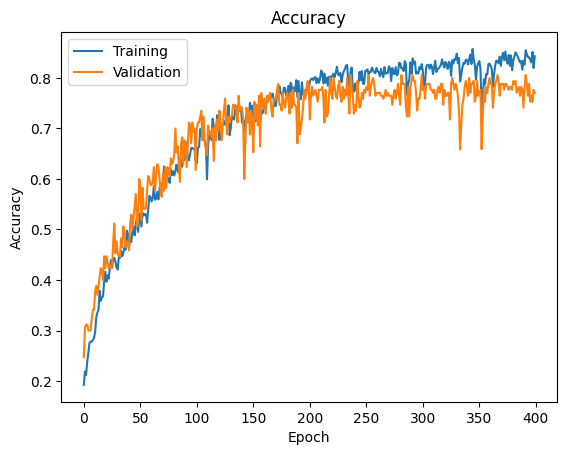

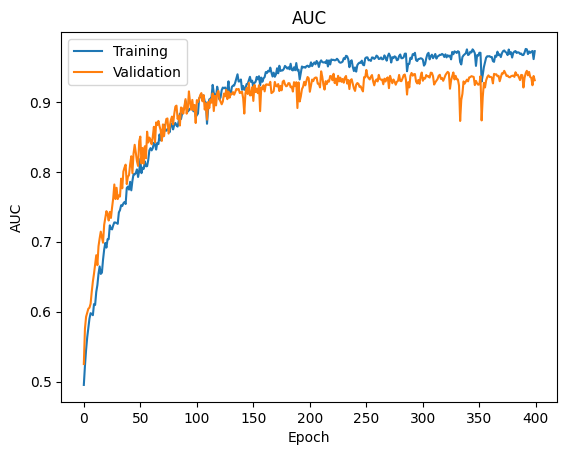

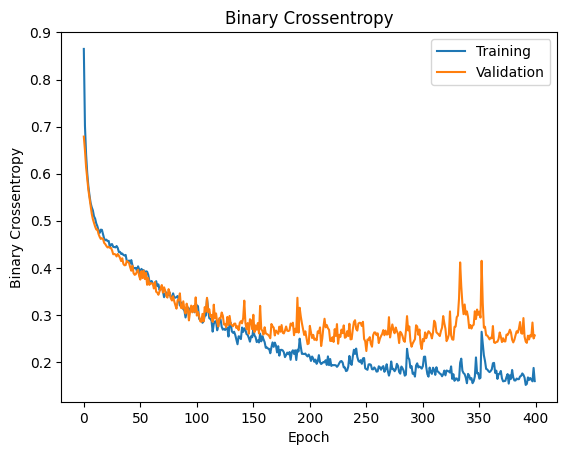

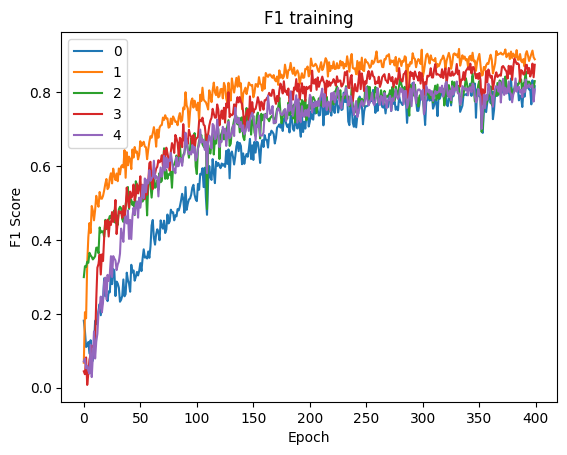

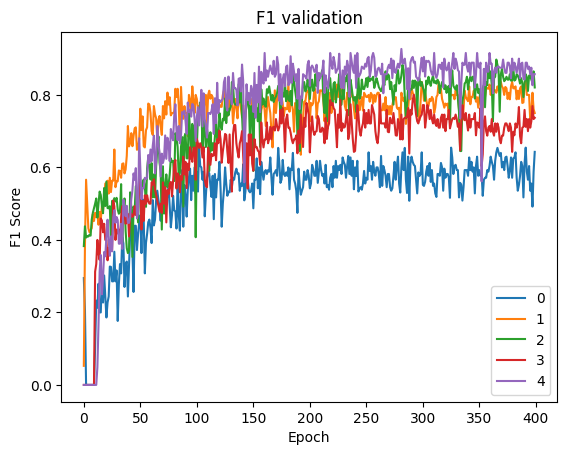

In [ ]:
for i in ['Accuracy', "AUC", "Binary Crossentropy"]:
  plt.title(i)
  plt.ylabel(i)
  if i == "Binary Crossentropy":
    low = 'loss'
  else:
    low = i.lower()
  plt.plot(history.history[low], label="Training")
  plt.plot(history.history['val_' + low], label="Validation")
  plt.xlabel("Epoch")
  plt.legend()
  plt.show()

plt.title("F1 training")
plt.plot(history.history['f1_score'], label=[0,1,2,3,4])
plt.legend()
plt.ylabel("F1 Score")
plt.xlabel("Epoch")
plt.show()

plt.title("F1 validation")
plt.plot(history.history['val_f1_score'], label=[0,1,2,3,4])
plt.legend()
plt.ylabel("F1 Score")
plt.xlabel("Epoch")
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


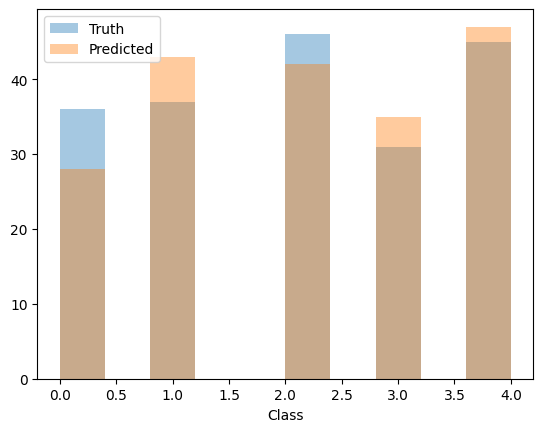

In [ ]:
plt.hist(np.argmax(y_test, axis=1), label = 'Truth', alpha = 0.4)
plt.hist(np.argmax(model.predict(X_test), axis=1), label="Predicted", alpha = 0.4)
plt.xlabel("Class")
plt.legend()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


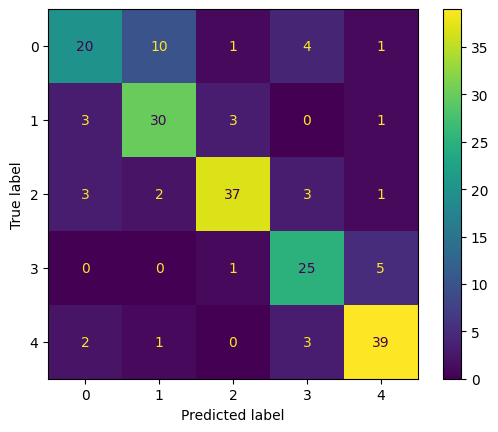

In [ ]:
a = ConfusionMatrixDisplay(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1)))
a.plot()
plt.show()

In [1]:
from sklearn.metrics import roc_auc_score
# Predict probabilities
y_pred = model.predict(X_test)    # shape (n_val, C)
class_names = [0,1,2,3,4]      # or your own list of length C

# Compute and print per‐class ROC-AUC
print("Per‐class ROC AUC on test set:")
for i, cls in enumerate(class_names):
    # roc_auc_score requires at least one positive & one negative example per class
    try:
        auc = roc_auc_score(y_test[:, i], y_pred[:, i])
        print(f"  Class {cls:<15} : AUC = {auc:.3f}")
    except ValueError as e:
        print(f"  Class {cls:<15} : could not compute AUC ({e})")

# --- 2b. Compute per‐class accuracy on the validation set ---
# y_pred: numpy array of shape (n_val, C), floats in [0,1]
# y_true: numpy array of shape (n_val, C), ints in {0,1}

# 1) Binarize predictions at 0.5
y_pred_label = (y_pred >= 0.5).astype(int)

# 2) Compute accuracy for each class (over all samples)
#    accuracy_i = (# correct on class i) / (total samples)
per_class_acc = (y_pred_label == y_test).sum(axis=0) / y_test.shape[0]

print("\nPer‐class Accuracy on validation set:")
for cls, acc in zip(class_names, per_class_acc):
    print(f"  Class {cls:<15} : Accuracy = {acc:.3f}")

NameError: name 'model' is not defined

---

# microcystin



In [3]:
# Load the training data
training_data_filename = '/content/training_data_SENTINEL (1).npy'
data = np.load(training_data_filename, allow_pickle=True)
print(f"Loaded {len(data)} entries from {training_data_filename}")

Loaded 1571 entries from /content/training_data_SENTINEL (1).npy


In [4]:
data[0][1]

'WE16'

In [5]:
# Determine feature vector size from first entry
first_entry = data[0]
if len(first_entry) < 3:
    raise ValueError("Unexpected entry format. Each entry should be (row_index, labels_array, patch_flat_array)")
first_patch = first_entry[3]
if not isinstance(first_patch, np.ndarray):
    raise ValueError("Patch data not found or not a numpy array.")

n_samples = len(data)
n_features = first_patch.size

# Initialize feature and label arrays
X = np.zeros((n_samples, n_features), dtype=float)
y = np.zeros(n_samples, dtype=float)
#truth = np.zeros(n_samples, dtype=int)

# Populate X and y
for idx, entry in enumerate(data):
    _, _, labels, patch_flat = entry
    # Feature: flatten reflectance array; assume consistent size
    patch_arr = patch_flat
    if patch_arr.size != n_features:
        raise ValueError(f"Inconsistent feature size at entry {idx}: expected {n_features}, got {patch_arr.size}")
    # Optionally handle NaNs in features; e.g., replace NaN with 0
    #patch_arr = np.nan_to_num(patch_arr, nan=0.0)
    X[idx, :] = patch_arr

    # Label: total microcystin > 0.1 µg/L
    if labels is None or len(labels) < 2:
        print(idx, entry, labels)
        total = 0.0
    else:
        part = labels[4] if not np.isnan(labels[4]) else 0.0
        part = part if part != 0 else 0.01
    y[idx] = part


# Display class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution (label: count):", dict(zip(unique, counts)))

# Save feature and label arrays if desired
np.save("X.npy", X)
np.save("y.npy", y)
print(f"Saved features to X.npy and labels to y.npy. X shape: {X.shape}, y shape: {y.shape}")

Class distribution (label: count): {np.float64(0.01): np.int64(744), np.float64(0.1): np.int64(17), np.float64(0.11): np.int64(19), np.float64(0.12): np.int64(15), np.float64(0.13): np.int64(22), np.float64(0.14): np.int64(15), np.float64(0.15): np.int64(21), np.float64(0.16): np.int64(10), np.float64(0.17): np.int64(10), np.float64(0.18): np.int64(9), np.float64(0.19): np.int64(15), np.float64(0.2): np.int64(6), np.float64(0.21): np.int64(5), np.float64(0.22): np.int64(12), np.float64(0.23): np.int64(3), np.float64(0.24): np.int64(2), np.float64(0.25): np.int64(11), np.float64(0.26): np.int64(1), np.float64(0.27): np.int64(3), np.float64(0.28): np.int64(5), np.float64(0.29): np.int64(11), np.float64(0.3): np.int64(5), np.float64(0.31): np.int64(2), np.float64(0.32): np.int64(9), np.float64(0.33): np.int64(1), np.float64(0.34): np.int64(1), np.float64(0.35): np.int64(5), np.float64(0.36): np.int64(6), np.float64(0.37): np.int64(1), np.float64(0.38): np.int64(3), np.float64(0.39): np.in

(array([744., 153.,  64.,  30.,  46.,  59.,  49.,  27.,  35.,  18.,  22.,
         18.,  24.,  14.,  20.,   7.,  21.,  21.,   3.,   2.,   5.,  19.,
         17.,  12.,   4.,  10.,   3.,   6.,   5.,   4.,   0.,   8.,   5.,
          5.,   9.,   0.,   4.,   0.,   1.,   2.,   2.,   0.,   2.,   2.,
          2.,   2.,   0.,   2.,   2.,   5.,   1.,   8.,   3.,   0.,   0.,
          0.,   0.,   0.,   3.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   5.,   1.,   0.,   3.,   9.,   0.,   2.,   0.,
          2.,   0.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
         3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
         4.4,  4.5,  4

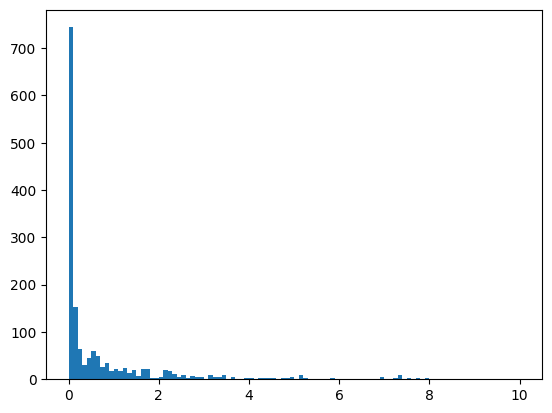

In [6]:
plt.hist(y, bins=100, range=(0, 10))

In [7]:
# reshape into images
X_temp = X.reshape((1571, 8, 8, 11))

# Generate and concatenate mask for NAN values
mask = np.any(~np.isnan(X_temp), axis=-1, keepdims=True).astype('float32')
temp = np.concatenate([X_temp, mask], axis=-1)  # (N,8,8,12)
print("After mask:", temp.shape)

# Normalizing content of x
means = np.nanmean(temp[..., :11], axis=(0,1,2))
stds  = np.nanstd(temp[..., :11], axis=(0,1,2))
# Broadcast and normalize
x_norm = temp.copy()
x_norm[..., :11] = (temp[..., :11] - means) / (stds + 1e-6)
print(x_norm.shape)

x_norm = np.nan_to_num(x_norm, nan=0.0)
x_norm.shape

After mask: (1571, 8, 8, 12)
(1571, 8, 8, 12)


(1571, 8, 8, 12)

In [76]:
# Flip on y-axis
flip_y = np.flip(x_norm, axis=2)

# Flip over X-axis
flip_x = np.flip(x_norm, axis=1)  # flip along height

# flip x and y
flip_xy = np.flip(flip_x, axis=2)

# Adding flipped images from array to-be-sampled from
x_norm = np.concatenate([x_norm, flip_y, flip_x, flip_xy], axis=0)
y = np.concatenate([y,y,y,y])
print(x_norm.shape, y.shape)

NameError: name 'X_norm' is not defined

In [74]:
y_temp >= 0.1

array([False, False, False, ..., False, False, False])

(array([2976.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3308.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

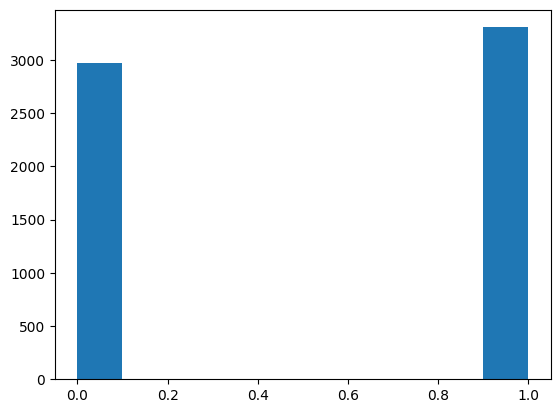

In [78]:
plt.hist((y >= 0.1).astype(int))

0.12


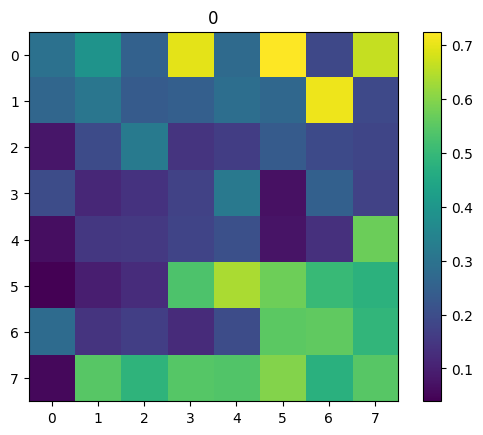

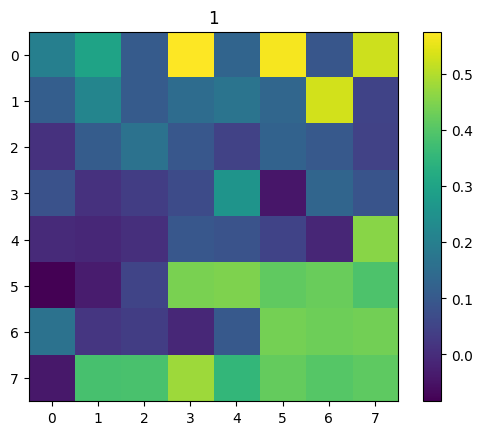

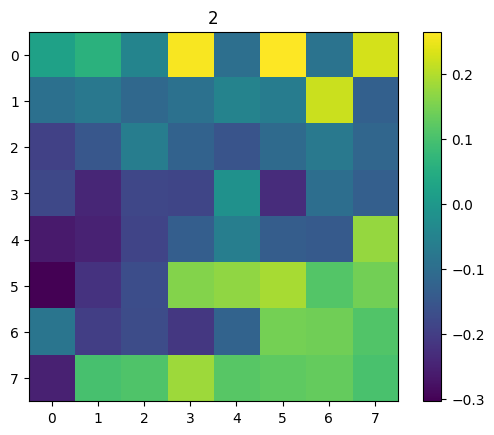

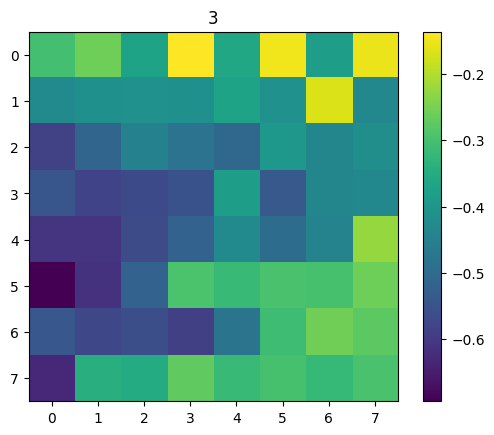

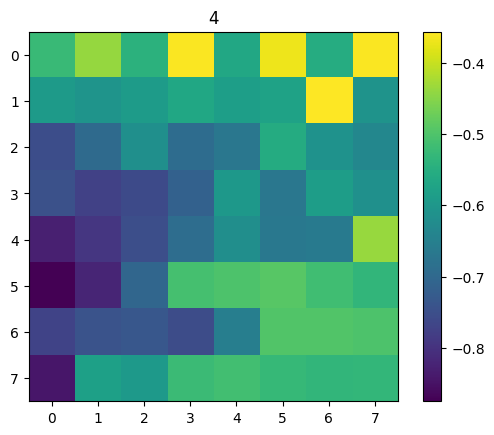

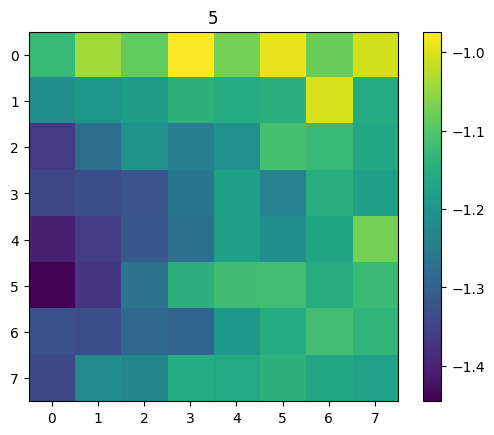

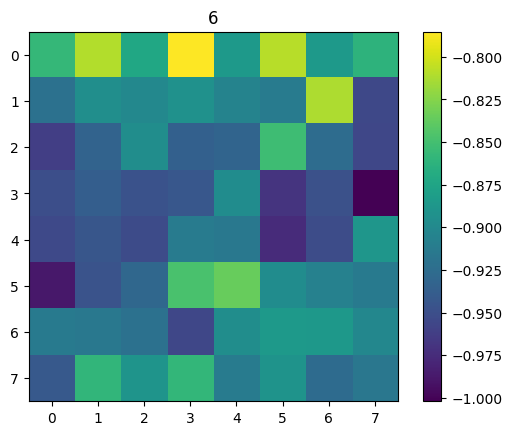

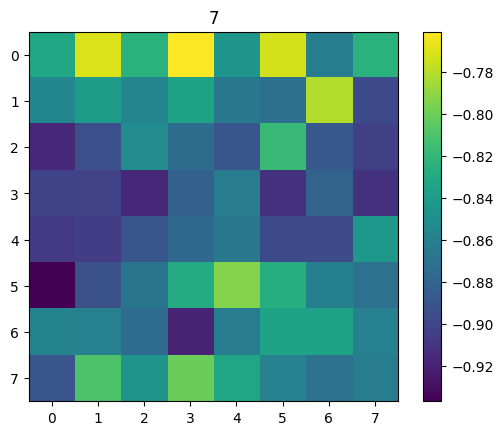

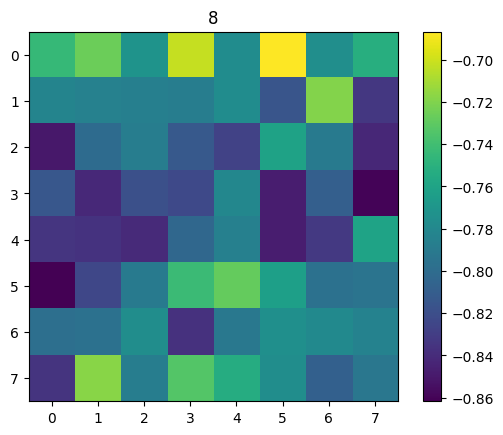

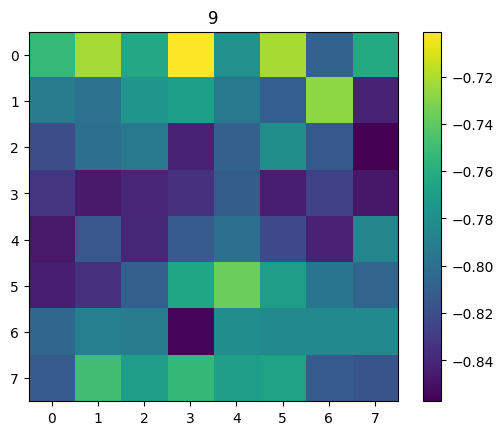

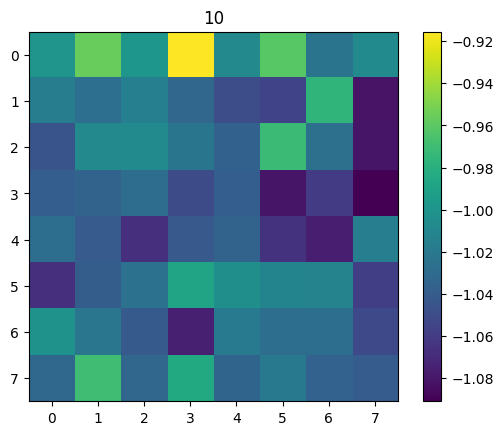

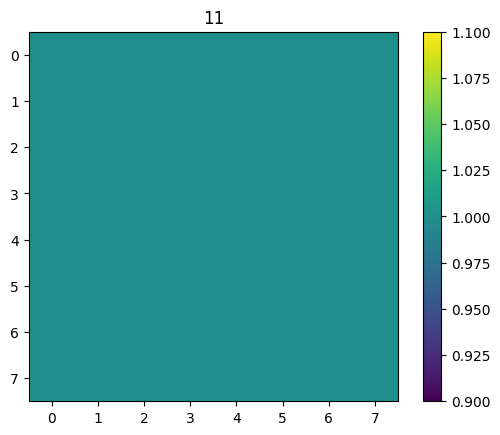

In [79]:
num = 745
print(y[num])
for i in range(12):
  plt.imshow(x_norm[num][:, :, i], cmap='viridis', interpolation='nearest')
  plt.colorbar()
  plt.title(i)
  plt.show()

In [80]:
X_temp, X_val, y_temp, y_val = train_test_split(x_norm, y, test_size=1/8, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=1/7, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, "\t", y_val.shape, "\t",y_test.shape)

(4712, 8, 8, 12) (786, 8, 8, 12) (786, 8, 8, 12)
(4712,) 	 (786,) 	 (786,)


In [81]:
checkpoint_callback = ModelCheckpoint(
    filepath="best_model.keras",         # file to save the best model
    monitor="val_loss",                  # metric to watch
    mode="min",                          # we want to minimize validation loss
    save_best_only=True,                 # only save when performance improves
    verbose=1
)

model = models.Sequential([
    layers.Input(shape=(8,8,12)),

    # Convolution layers
    layers.Conv2D(32, kernel_size=(1, 1), activation='relu', padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, kernel_size=(1, 1), activation='relu', padding='same', use_bias=False),
    layers.BatchNormalization(),

    # Flatten spatial dims into instance dimension
    layers.Reshape((4*4, 64)),          # (batch,100,64)
    # Per-instance embedding

    layers.Conv1D(64, 1, activation='relu'),
    layers.Dropout(0.2),

    layers.GlobalMaxPooling1D(),

    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4, activation='relu'),
    layers.Dropout(0.2),

    # Output layer: 1
    layers.Dense(1, activation='relu')
])

# Compile
# 0.0001 -> val loss 1.38924, test 19.41665
# 0.00005 -> 1.52
model.compile(optimizer= optimizers.Adam(learning_rate=0.00003),
              loss='MSE', metrics=["MAE"])

# Summary
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=64, verbose=2, callbacks=[checkpoint_callback])

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 32)       │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 64)       │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 16, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_8          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 4)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,193 (35.91 KB)

 Trainable params: 9,001 (35.16 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/300

Epoch 1: val_loss improved from inf to 3.62717, saving model to best_model.keras
74/74 - 4s - 59ms/step - MAE: 0.9615 - loss: 8.6835 - val_MAE: 0.7946 - val_loss: 3.6272
Epoch 2/300

Epoch 2: val_loss improved from 3.62717 to 3.49503, saving model to best_model.keras
74/74 - 2s - 30ms/step - MAE: 0.9413 - loss: 8.3329 - val_MAE: 0.7760 - val_loss: 3.4950
Epoch 3/300

Epoch 3: val_loss improved from 3.49503 to 3.30692, saving model to best_model.keras
74/74 - 1s - 14ms/step - MAE: 0.9086 - loss: 8.0667 - val_MAE: 0.7559 - val_loss: 3.3069
Epoch 4/300

Epoch 4: val_loss improved from 3.30692 to 3.10569, saving model to best_model.keras
74/74 - 1s - 17ms/step - MAE: 0.9041 - loss: 7.7143 - val_MAE: 0.7426 - val_loss: 3.1057
Epoch 5/300

Epoch 5: val_loss improved from 3.10569 to 2.93971, saving model to best_model.keras
74/74 - 2s - 22ms/step - MAE: 0.8979 - loss: 7.6511 - val_MAE: 0.7303 - val_loss: 2.9397
Epoch 6/300

Epoch 6: val_loss improved from 2.93971 to 2.82182, savi

In [106]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=64, verbose=2, callbacks=[checkpoint_callback])

Epoch 1/300

Epoch 1: val_loss did not improve from 0.58394
74/74 - 1s - 13ms/step - MAE: 0.4590 - loss: 1.8248 - val_MAE: 0.3812 - val_loss: 0.6232
Epoch 2/300

Epoch 2: val_loss did not improve from 0.58394
74/74 - 1s - 13ms/step - MAE: 0.4504 - loss: 1.5552 - val_MAE: 0.3804 - val_loss: 0.6185
Epoch 3/300

Epoch 3: val_loss did not improve from 0.58394
74/74 - 1s - 18ms/step - MAE: 0.4494 - loss: 1.9946 - val_MAE: 0.3886 - val_loss: 0.6543
Epoch 4/300

Epoch 4: val_loss did not improve from 0.58394
74/74 - 1s - 20ms/step - MAE: 0.4539 - loss: 2.0226 - val_MAE: 0.3798 - val_loss: 0.6137
Epoch 5/300

Epoch 5: val_loss did not improve from 0.58394
74/74 - 3s - 35ms/step - MAE: 0.4521 - loss: 1.4550 - val_MAE: 0.3761 - val_loss: 0.6011
Epoch 6/300

Epoch 6: val_loss did not improve from 0.58394
74/74 - 2s - 28ms/step - MAE: 0.4658 - loss: 1.8578 - val_MAE: 0.3752 - val_loss: 0.6010
Epoch 7/300

Epoch 7: val_loss did not improve from 0.58394
74/74 - 1s - 13ms/step - MAE: 0.4569 - loss: 1

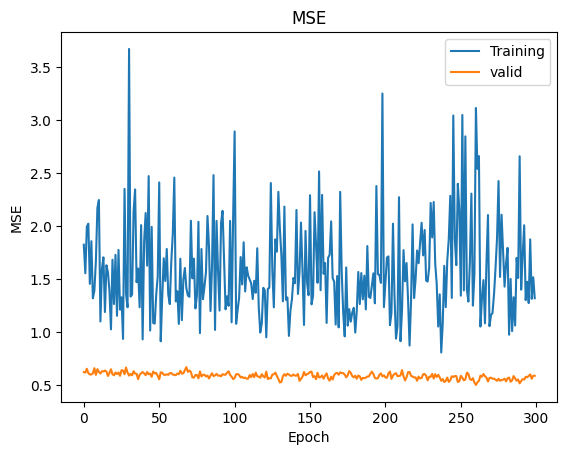

In [107]:
plt.title("MSE")
plt.plot(history.history['loss'], label="Training")
plt.plot(history.history['val_loss'], label="valid")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.show()

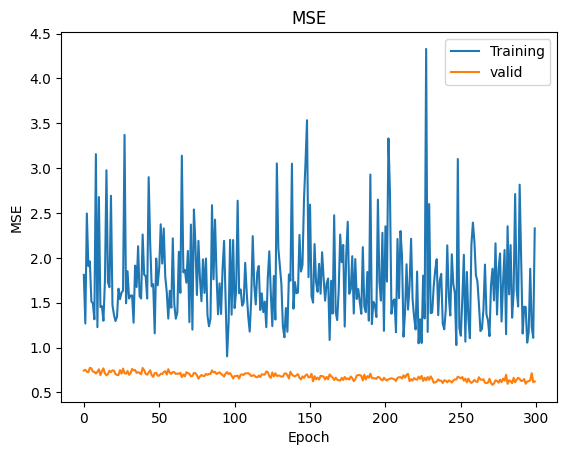

In [102]:
plt.title("MSE")
plt.plot(history.history['loss'], label="Training")
plt.plot(history.history['val_loss'], label="valid")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.show()

In [114]:
y_pred = model.predict(X_test)
print(mean_squared_error(y_pred, y_test))

pred_2 = load_model("best_model.keras").predict(X_train)
print(mean_squared_error(pred_2, y_train))

# prediction of best model
pred_2 = load_model("best_model.keras").predict(X_test)
print(mean_squared_error(pred_2, y_test))


# prediction of best model
pred_3 = load_model("best_model.keras").predict(x_norm)
print(mean_squared_error(pred_3, y))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
0.41711624003181974
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
0.49620063088392197
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
0.34067109910144655
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
0.47749637271171746


In [115]:
# Double checking
np.sum(((y_pred.reshape(786) - y_test) **2))/len(y_pred)

np.float64(0.41711624003181974)

In [118]:
# accuracy
print("Acc1:", np.sum((y_pred.reshape(786) >= 0.1) == (y_test >= 0.1))/len(y_pred))
print("Acc2:", np.sum((pred_2.reshape(786) >= 0.1) == (y_test >= 0.1))/len(y_pred))
print("Acc3:", np.sum((pred_3.reshape(6284) >= 0.1) == (y >= 0.1))/len(y_pred))

Acc1: 0.8536895674300254
Acc2: 0.8473282442748091
Acc3: 6.768447837150127


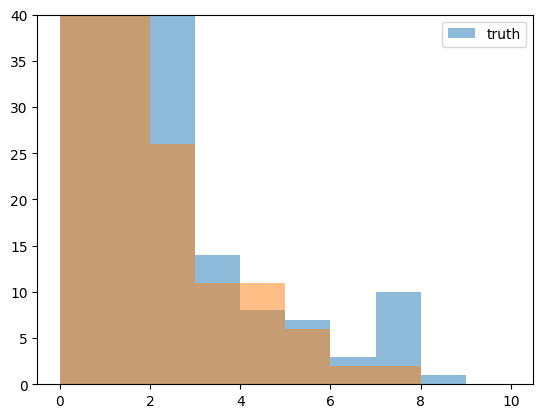

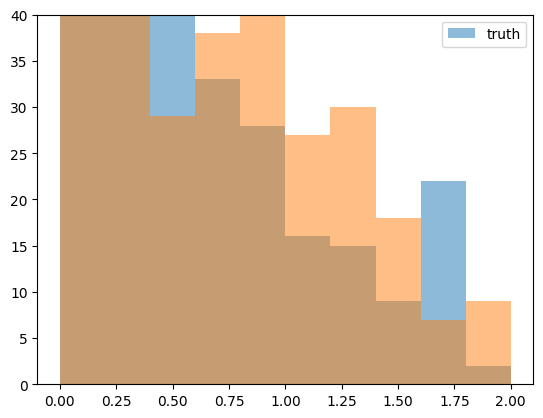

In [128]:
plt.hist(y_test, alpha=0.5, bins =10, range=(0,10), label="truth")
plt.hist(y_pred, alpha=0.5, bins =10, range=(0,10))
plt.ylim(0,40)
plt.legend()
plt.show()
plt.hist(y_test, alpha=0.5, bins =10, range=(0,2), label="truth")
plt.hist(pred_2, alpha=0.5, bins =10, range=(0,2))
plt.ylim(0,40)
plt.legend()
plt.show()

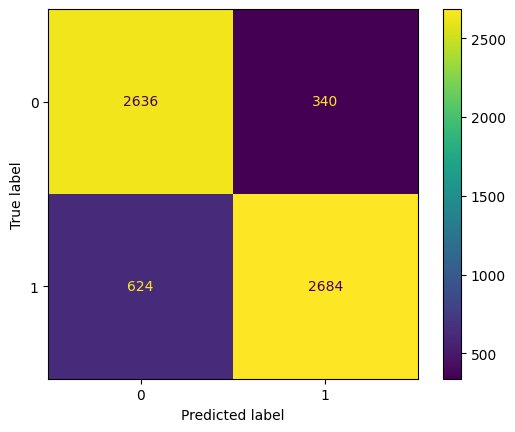

In [125]:
a = ConfusionMatrixDisplay(confusion_matrix(y >= 0.1, pred_3.reshape(6284) >= 0.1))
a.plot()
plt.show()

In [39]:
ty_train = (y_train >= 0.1).reshape(-1, 1)
ty_val = (y_val >= 0.1).reshape(-1, 1)
ty_test = (y_test >= 0.1).reshape(-1, 1)
print(ty_train)

[[False]
 [ True]
 [ True]
 ...
 [ True]
 [ True]
 [False]]


In [45]:
checkpoint_callback2 = ModelCheckpoint(
    filepath="best_model2.keras",         # file to save the best model
    monitor="val_accuracy",                  # metric to watch
    mode="max",                          # we want to minimize validation loss
    save_best_only=True,                 # only save when performance improves
    verbose=1
)
model = models.Sequential([
    layers.Input(shape=(8,8,12)),

    # Convolution layers
    layers.Conv2D(32, kernel_size=(1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=(1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),

    # Flatten spatial dims into instance dimension
    layers.Reshape((8*8, 64)),          # (batch,100,64)
    # Per-instance embedding

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),

    layers.GlobalMaxPooling1D(),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),


    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(15, activation='relu'),
    layers.Dropout(0.2),

    # Output layer: Single probability
    layers.Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer= optimizers.Adam(learning_rate=0.00005),
              # Each class is binary
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), 'f1_score'])

# Summary
model.summary()
history = model.fit(X_train, ty_train, validation_data=(X_val, ty_val), epochs=300, batch_size=64, verbose=2, callbacks=[checkpoint_callback2])

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 32)       │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 64)       │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64, 128)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_7          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 15)             │           495 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,335 (87.25 KB)

 Trainable params: 22,015 (86.00 KB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/300

Epoch 1: val_accuracy improved from -inf to 0.43655, saving model to best_model2.keras
19/19 - 10s - 517ms/step - accuracy: 0.5361 - auc: 0.5834 - f1_score: 0.6849 - loss: 0.7693 - val_accuracy: 0.4365 - val_auc: 0.3946 - val_f1_score: 0.7124 - val_loss: 0.6970
Epoch 2/300

Epoch 2: val_accuracy improved from 0.43655 to 0.49746, saving model to best_model2.keras
19/19 - 1s - 38ms/step - accuracy: 0.5794 - auc: 0.6471 - f1_score: 0.6849 - loss: 0.7179 - val_accuracy: 0.4975 - val_auc: 0.4975 - val_f1_score: 0.7124 - val_loss: 0.6934
Epoch 3/300

Epoch 3: val_accuracy improved from 0.49746 to 0.52792, saving model to best_model2.keras
19/19 - 1s - 65ms/step - accuracy: 0.5803 - auc: 0.6704 - f1_score: 0.6849 - loss: 0.6875 - val_accuracy: 0.5279 - val_auc: 0.5905 - val_f1_score: 0.7124 - val_loss: 0.6905
Epoch 4/300

Epoch 4: val_accuracy improved from 0.52792 to 0.58376, saving model to best_model2.keras
19/19 - 1s - 36ms/step - accuracy: 0.6058 - auc: 0.7058 - f1_score: 0.

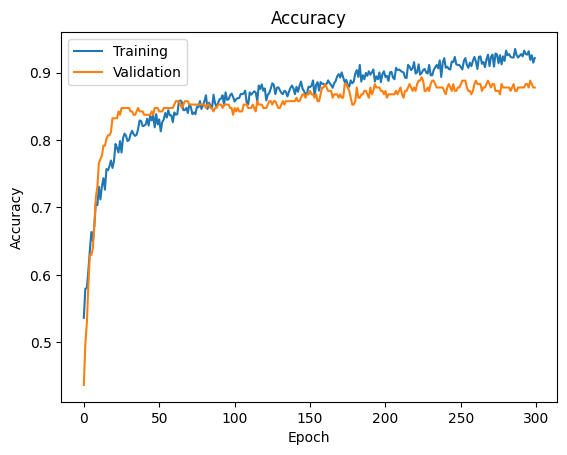

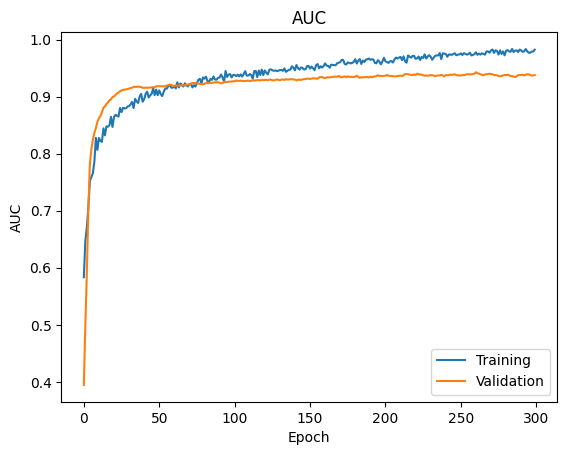

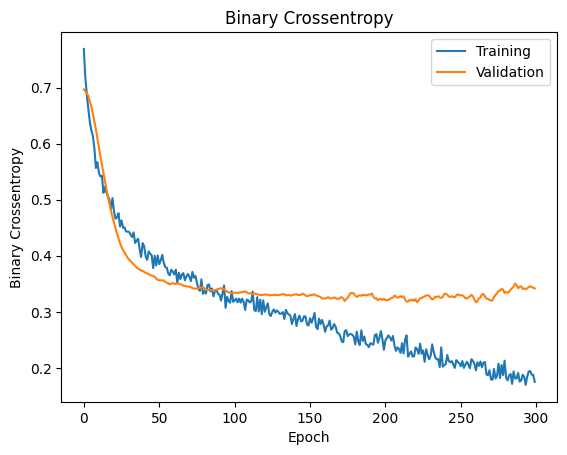

/tmp/ipython-input-46-3409924481.py:15: MatplotlibDeprecationWarning: Passing label as a length 5 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(history.history['f1_score'], label=[0,1,2,3,4])


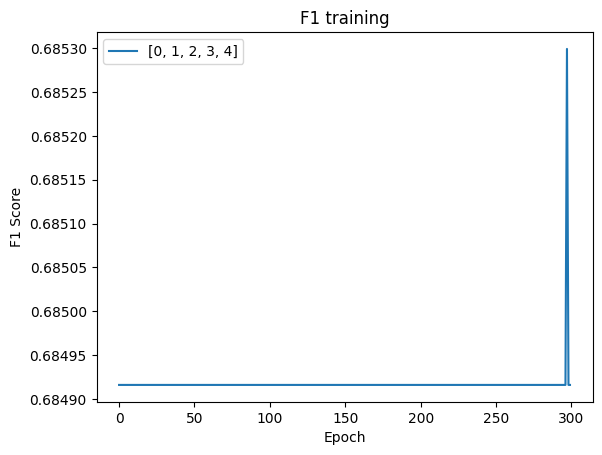

/tmp/ipython-input-46-3409924481.py:22: MatplotlibDeprecationWarning: Passing label as a length 5 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(history.history['val_f1_score'], label=[0,1,2,3,4])


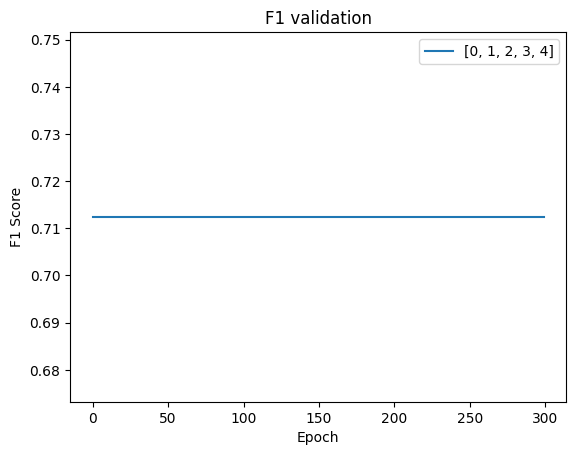

In [46]:
for i in ['Accuracy', "AUC", "Binary Crossentropy"]:
  plt.title(i)
  plt.ylabel(i)
  if i == "Binary Crossentropy":
    low = 'loss'
  else:
    low = i.lower()
  plt.plot(history.history[low], label="Training")
  plt.plot(history.history['val_' + low], label="Validation")
  plt.xlabel("Epoch")
  plt.legend()
  plt.show()

plt.title("F1 training")
plt.plot(history.history['f1_score'], label=[0,1,2,3,4])
plt.legend()
plt.ylabel("F1 Score")
plt.xlabel("Epoch")
plt.show()

plt.title("F1 validation")
plt.plot(history.history['val_f1_score'], label=[0,1,2,3,4])
plt.legend()
plt.ylabel("F1 Score")
plt.xlabel("Epoch")
plt.show()

In [60]:
y_pred_label = (model.predict(X_test) >= 0.5).astype(int)

# 2) Compute accuracy for each class (over all samples)
#    accuracy_i = (# correct on class i) / (total samples)
(y_pred_label == ty_test).sum(axis=0) / y_test.shape[0]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


array([0.86294416])

---
# Microcycstin with PACE

In [76]:
# Load the training data
training_data_filename = '/content/training_data_PACE.npy'
data = np.load(training_data_filename, allow_pickle=True)
print(f"Loaded {len(data)} entries from {training_data_filename}")

Loaded 382 entries from /content/training_data_PACE.npy


In [ ]:
# Determine feature vector size from first entry
first_entry = data[0]
if len(first_entry) < 3:
    raise ValueError("Unexpected entry format. Each entry should be (row_index, labels_array, patch_flat_array)")
first_patch = first_entry[3]
if not isinstance(first_patch, np.ndarray):
    raise ValueError("Patch data not found or not a numpy array.")

n_samples = len(data)
n_features = first_patch.size

# Initialize feature and label arrays
X = np.zeros((n_samples, n_features), dtype=float)
y = np.zeros(n_samples, dtype=float)
#truth = np.zeros(n_samples, dtype=int)

# Populate X and y
for idx, entry in enumerate(data):
    _, _, labels, patch_flat = entry
    # Feature: flatten reflectance array; assume consistent size
    patch_arr = patch_flat
    if patch_arr.size != n_features:
        raise ValueError(f"Inconsistent feature size at entry {idx}: expected {n_features}, got {patch_arr.size}")
    # Optionally handle NaNs in features; e.g., replace NaN with 0
    #patch_arr = np.nan_to_num(patch_arr, nan=0.0)
    X[idx, :] = patch_arr

    # Label: total microcystin > 0.1 µg/L
    if labels is None or len(labels) < 2:
        print(idx, entry, labels)
        total = 0.0
    else:
        part = labels[4] if not np.isnan(labels[4]) else 0.0
        part = part if part != 0 else 0.01
    y[idx] = part


# Display class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution (label: count):", dict(zip(unique, counts)))

# Save feature and label arrays if desired
np.save("X.npy", X)
np.save("y.npy", y)
print(f"Saved features to X.npy and labels to y.npy. X shape: {X.shape}, y shape: {y.shape}")

Class distribution (label: count): {np.float64(0.01): np.int64(191), np.float64(0.13): np.int64(4), np.float64(0.14): np.int64(8), np.float64(0.15): np.int64(1), np.float64(0.16): np.int64(1), np.float64(0.165038103): np.int64(2), np.float64(0.18): np.int64(1), np.float64(0.21): np.int64(8), np.float64(0.23): np.int64(5), np.float64(0.24): np.int64(4), np.float64(0.26): np.int64(2), np.float64(0.28): np.int64(3), np.float64(0.29): np.int64(2), np.float64(0.3): np.int64(4), np.float64(0.32): np.int64(4), np.float64(0.33): np.int64(1), np.float64(0.34): np.int64(8), np.float64(0.35): np.int64(3), np.float64(0.39): np.int64(1), np.float64(0.4): np.int64(8), np.float64(0.42): np.int64(3), np.float64(0.429349098): np.int64(2), np.float64(0.43): np.int64(1), np.float64(0.44): np.int64(2), np.float64(0.45): np.int64(1), np.float64(0.49): np.int64(6), np.float64(0.5): np.int64(3), np.float64(0.57): np.int64(3), np.float64(0.64): np.int64(2), np.float64(0.73): np.int64(3), np.float64(0.74): np.

(array([191.,  17.,  28.,  17.,  23.,   6.,   2.,   7.,   2.,   1.,   9.,
          0.,   8.,   3.,   0.,   4.,   2.,   0.,   8.,   2.,   7.,   0.,
          0.,   6.,   0.,   0.,   4.,   0.,   0.,   3.,   4.,   0.,   0.,
          0.,   1.,   0.,   1.,   6.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,
          2.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
         3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
         4.4,  4.5,  4

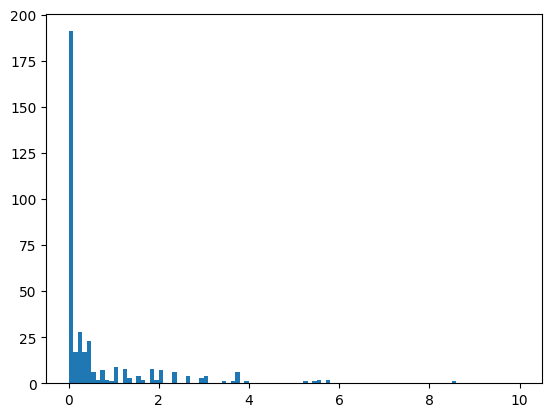

In [78]:
plt.hist(y, bins=100, range=(0, 10))

In [79]:
np.sum(y>=0.1)

np.int64(191)

In [80]:
# reshape into images
X_temp = X.reshape((382, 5, 5, 172))

# Generate and concatenate mask for NAN values
mask = np.any(~np.isnan(X_temp), axis=-1, keepdims=True).astype('float32')
temp = np.concatenate([X_temp, mask], axis=-1)
print("After mask:", temp.shape)

# Normalizing content of x
means = np.nanmean(temp[..., :11], axis=(0,1,2))
stds  = np.nanstd(temp[..., :11], axis=(0,1,2))
# Broadcast and normalize
x_norm = temp.copy()
x_norm[..., :11] = (temp[..., :11] - means) / (stds + 1e-6)
print(x_norm.shape)

x_norm = np.nan_to_num(x_norm, nan=0.0)

# Flip on y-axis
flip_y = np.flip(x_norm, axis=2)

# Flip over X-axis
flip_x = np.flip(x_norm, axis=1)  # flip along height

# flip x and y
flip_xy = np.flip(flip_x, axis=2)

# Adding flipped images from array to-be-sampled from
x_norm = np.concatenate([x_norm, flip_y, flip_x, flip_xy], axis=0)
y = np.concatenate([y,y,y,y])
print(x_norm.shape, y.shape)

After mask: (382, 5, 5, 173)
(382, 5, 5, 173)
(1528, 5, 5, 173) (1528,)


(array([764.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 764.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

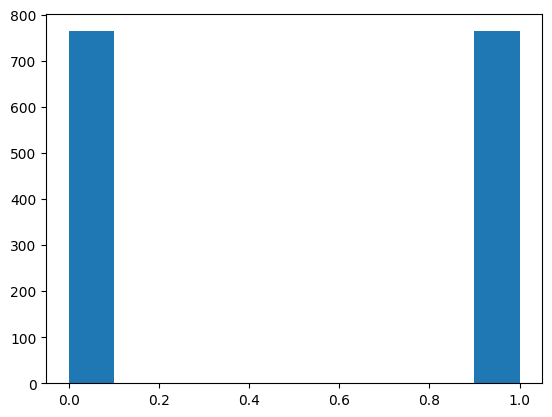

In [81]:
plt.hist((y >= 0.1).astype(int))

In [82]:
import hashlib

# Assuming `data` is your array of shape (1528, 5, 5, 173)
# Example: data = np.random.rand(1528, 5, 5, 173)

hashes = []
hash_to_index = {}

for i, sample in enumerate(x_norm):
    # Flatten and convert to bytes
    sample_bytes = sample.tobytes()
    # Hash using SHA256
    sample_hash = hashlib.sha256(sample_bytes).hexdigest()
    hashes.append(sample_hash)

    if sample_hash in hash_to_index:
        print(f"Duplicate found: Sample {i} is a duplicate of Sample {hash_to_index[sample_hash]}")
    else:
        hash_to_index[sample_hash] = i

Duplicate found: Sample 193 is a duplicate of Sample 189
Duplicate found: Sample 575 is a duplicate of Sample 571
Duplicate found: Sample 957 is a duplicate of Sample 953
Duplicate found: Sample 1339 is a duplicate of Sample 1335


In [83]:
X_temp, X_val, y_temp, y_val = train_test_split(x_norm, y, test_size=1/8, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=1/7, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, "\t", y_val.shape, "\t",y_test.shape)

(1146, 5, 5, 173) (191, 5, 5, 173) (191, 5, 5, 173)
(1146,) 	 (191,) 	 (191,)


## SETUP FINISHED

In [17]:
checkpoint_callback = ModelCheckpoint(
    filepath="best_model.keras",         # file to save the best model
    monitor="val_loss",                  # metric to watch
    mode="min",                          # we want to minimize validation loss
    save_best_only=True,                 # only save when performance improves
    verbose=1
)

model = models.Sequential([
    layers.Input(shape=(5,5,173)),

    # Convolution layers
    layers.Conv2D(32, kernel_size=(1, 1), activation='relu', padding='same', use_bias=False),
    layers.BatchNormalization(),
    #layers.MaxPooling2D(2),
    layers.Conv2D(64, kernel_size=(1, 1), activation='relu', padding='same', use_bias=False),
    layers.BatchNormalization(),

    # Flatten spatial dims into instance dimension
    layers.Reshape((5*5, 64)),          # (batch,100,64)
    # Per-instance embedding

    layers.Conv1D(64, 1, activation='relu'),
    layers.Dropout(0.1),

    layers.GlobalMaxPooling1D(),

    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(4, activation='relu'),
    layers.Dropout(0.1),

    # Output layer: 1
    layers.Dense(1, activation='relu')
])

# Compile
# 0.0001 -> val loss 1.38924, test 19.41665
# 0.00005 -> 1.52
model.compile(optimizer= optimizers.Adam(learning_rate=0.0001),
              loss='MSE', metrics=["MAE"])

# Summary
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=64, verbose=2, callbacks=[checkpoint_callback])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 32)       │         5,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 5, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 64)       │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 25, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,345 (56.04 KB)

 Trainable params: 14,153 (55.29 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/300

Epoch 1: val_loss improved from inf to 25.42423, saving model to best_model.keras
18/18 - 5s - 251ms/step - MAE: 1.2556 - loss: 18.4170 - val_MAE: 1.2976 - val_loss: 25.4242
Epoch 2/300

Epoch 2: val_loss improved from 25.42423 to 25.42268, saving model to best_model.keras
18/18 - 0s - 19ms/step - MAE: 1.2555 - loss: 18.4167 - val_MAE: 1.2975 - val_loss: 25.4227
Epoch 3/300

Epoch 3: val_loss improved from 25.42268 to 25.42266, saving model to best_model.keras
18/18 - 1s - 32ms/step - MAE: 1.2550 - loss: 18.4141 - val_MAE: 1.2975 - val_loss: 25.4227
Epoch 4/300

Epoch 4: val_loss improved from 25.42266 to 25.41960, saving model to best_model.keras
18/18 - 0s - 18ms/step - MAE: 1.2541 - loss: 18.4128 - val_MAE: 1.2970 - val_loss: 25.4196
Epoch 5/300

Epoch 5: val_loss improved from 25.41960 to 25.40166, saving model to best_model.keras
18/18 - 0s - 17ms/step - MAE: 1.2494 - loss: 18.3881 - val_MAE: 1.2943 - val_loss: 25.4017
Epoch 6/300

Epoch 6: val_loss improved from 25.4

In [23]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=64, verbose=2, callbacks=[checkpoint_callback])

Epoch 1/1000

Epoch 1: val_loss did not improve from 4.25834
18/18 - 1s - 40ms/step - MAE: 0.6402 - loss: 3.8375 - val_MAE: 0.5868 - val_loss: 4.7144
Epoch 2/1000

Epoch 2: val_loss did not improve from 4.25834
18/18 - 1s - 57ms/step - MAE: 0.6527 - loss: 3.3479 - val_MAE: 0.6078 - val_loss: 4.5364
Epoch 3/1000

Epoch 3: val_loss did not improve from 4.25834
18/18 - 1s - 31ms/step - MAE: 0.6501 - loss: 3.1468 - val_MAE: 0.6292 - val_loss: 4.6087
Epoch 4/1000

Epoch 4: val_loss did not improve from 4.25834
18/18 - 0s - 22ms/step - MAE: 0.6828 - loss: 4.5029 - val_MAE: 0.5939 - val_loss: 4.5927
Epoch 5/1000

Epoch 5: val_loss did not improve from 4.25834
18/18 - 1s - 29ms/step - MAE: 0.7651 - loss: 6.5458 - val_MAE: 0.6222 - val_loss: 4.6091
Epoch 6/1000

Epoch 6: val_loss did not improve from 4.25834
18/18 - 0s - 13ms/step - MAE: 0.6489 - loss: 3.4803 - val_MAE: 0.7309 - val_loss: 4.8754
Epoch 7/1000

Epoch 7: val_loss did not improve from 4.25834
18/18 - 0s - 16ms/step - MAE: 0.6375 - 

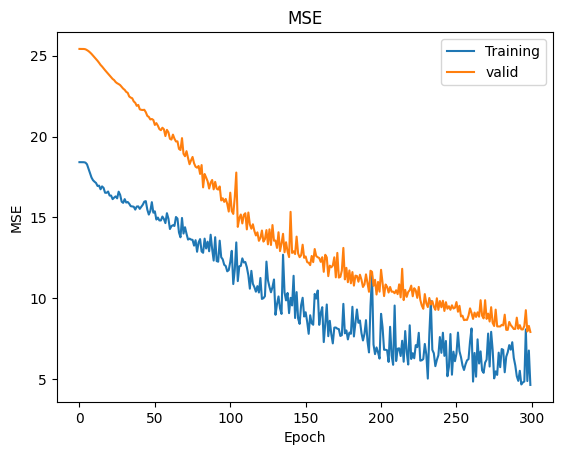

In [18]:
plt.title("MSE")
plt.plot(history.history['loss'], label="Training")
plt.plot(history.history['val_loss'], label="valid")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.show()

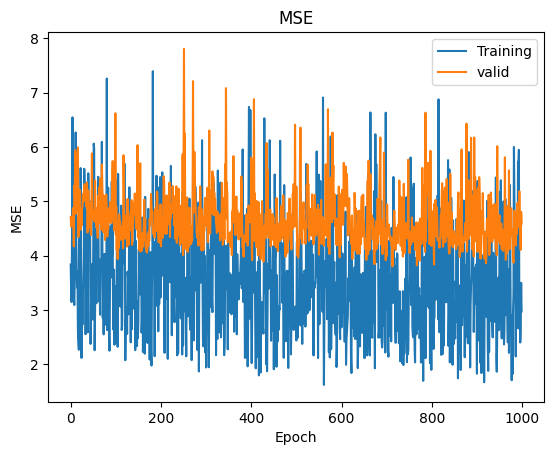

In [24]:
plt.title("MSE")
plt.plot(history.history['loss'], label="Training")
plt.plot(history.history['val_loss'], label="valid")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4.696666321386732


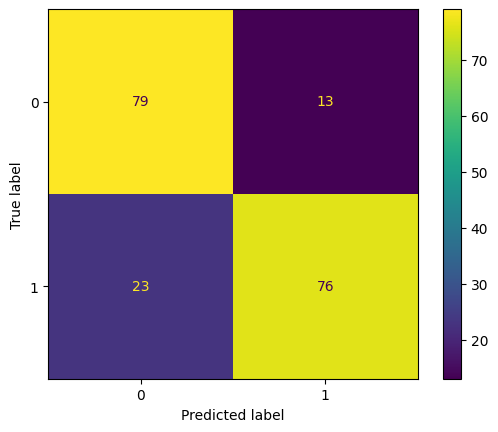

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1.6986952716907469
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4.208903820415222


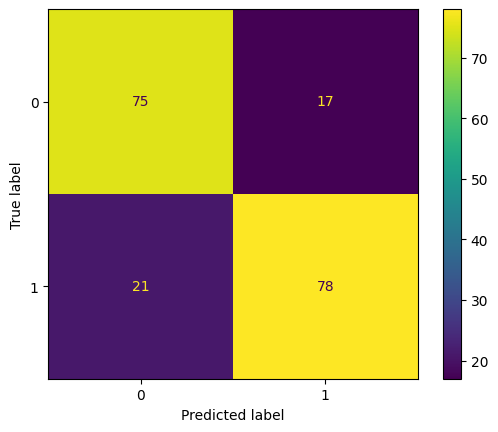

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
2.275586173700835


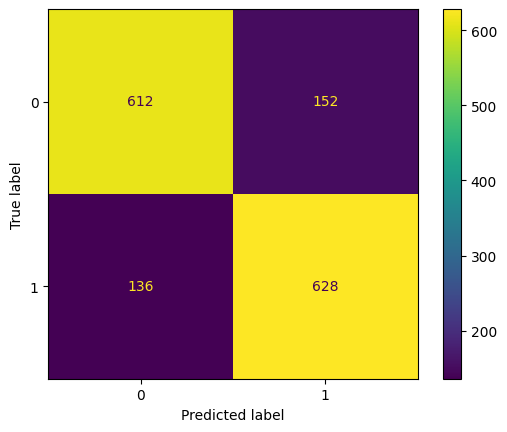

In [33]:
# MSE for testing
y_pred = model.predict(X_test)
print(mean_squared_error(y_pred, y_test))
a = ConfusionMatrixDisplay(confusion_matrix(y_test >= 0.1, y_pred.reshape(191) >= 0.1))
a.plot()
plt.show()

# MSE for training
pred_2 = load_model("best_model.keras").predict(X_train)
print(mean_squared_error(pred_2, y_train))

# prediction of best model (testing)
pred_2 = load_model("best_model.keras").predict(X_test)
print(mean_squared_error(pred_2, y_test))
a = ConfusionMatrixDisplay(confusion_matrix(y_test >= 0.1, pred_2.reshape(191) >= 0.1))
a.plot()
plt.show()

# prediction of best model (entire dataset)
pred_3 = load_model("best_model.keras").predict(x_norm)
print(mean_squared_error(pred_3, y))

#1528
a = ConfusionMatrixDisplay(confusion_matrix(y >= 0.1, pred_3.reshape(1528) >= 0.1))
a.plot()
plt.show()

In [34]:
ty_train = (y_train >= 0.1).reshape(-1, 1)
ty_val = (y_val >= 0.1).reshape(-1, 1)
ty_test = (y_test >= 0.1).reshape(-1, 1)
print(ty_train)

[[False]
 [False]
 [ True]
 ...
 [ True]
 [ True]
 [False]]


---
# Microcycstin with PACE (binary classification)

In [84]:
checkpoint_callback2 = ModelCheckpoint(
    filepath="best_model2.keras",         # file to save the best model
    monitor="val_accuracy",                  # metric to watch
    mode="max",                          # we want to minimize validation loss
    save_best_only=True,                 # only save when performance improves
    verbose=1
)
model2 = models.Sequential([
    layers.Input(shape=(5,5,173)),

    # Convolution layers
    layers.Conv2D(32, kernel_size=(1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=(1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),

    # Flatten spatial dims into instance dimension
    layers.Reshape((5*5, 64)),          # (batch,100,64)
    # Per-instance embedding

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),

    layers.GlobalMaxPooling1D(),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),


    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(4, activation='relu'),
    layers.Dropout(0.1),

    # Output layer: Single probability
    layers.Dense(1, activation='sigmoid')
])

# Compile
model2.compile(optimizer= optimizers.Adam(learning_rate=0.0001),
              # Each class is binary
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Summary
model2.summary()
history2 = model2.fit(X_train, ty_train, validation_data=(X_val, ty_val), epochs=300, batch_size=64, verbose=2, callbacks=[checkpoint_callback2])

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 5, 5, 32)       │         5,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 5, 5, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 5, 5, 64)       │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_10 (Reshape)            │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 25, 128)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_11         │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 4)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,113 (105.91 KB)

 Trainable params: 26,793 (104.66 KB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/300

Epoch 1: val_accuracy improved from -inf to 0.60733, saving model to best_model2.keras
18/18 - 6s - 334ms/step - accuracy: 0.5279 - auc: 0.5593 - loss: 0.7226 - val_accuracy: 0.6073 - val_auc: 0.6422 - val_loss: 0.6879
Epoch 2/300

Epoch 2: val_accuracy did not improve from 0.60733
18/18 - 0s - 18ms/step - accuracy: 0.5960 - auc: 0.6456 - loss: 0.6763 - val_accuracy: 0.5131 - val_auc: 0.6404 - val_loss: 0.6897
Epoch 3/300

Epoch 3: val_accuracy did not improve from 0.60733
18/18 - 0s - 19ms/step - accuracy: 0.6099 - auc: 0.6809 - loss: 0.6480 - val_accuracy: 0.4921 - val_auc: 0.6798 - val_loss: 0.6900
Epoch 4/300

Epoch 4: val_accuracy did not improve from 0.60733
18/18 - 0s - 17ms/step - accuracy: 0.6518 - auc: 0.7176 - loss: 0.6274 - val_accuracy: 0.4974 - val_auc: 0.6486 - val_loss: 0.6907
Epoch 5/300

Epoch 5: val_accuracy did not improve from 0.60733
18/18 - 1s - 34ms/step - accuracy: 0.6684 - auc: 0.7307 - loss: 0.6197 - val_accuracy: 0.4817 - val_auc: 0.6880 - val_l

In [65]:
history2.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'val_accuracy', 'val_auc', 'val_loss'])

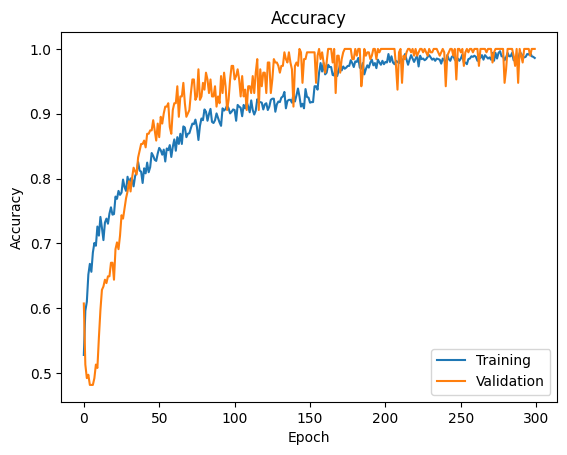

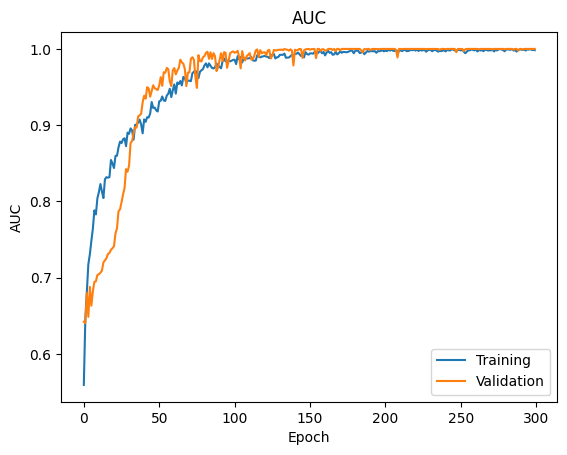

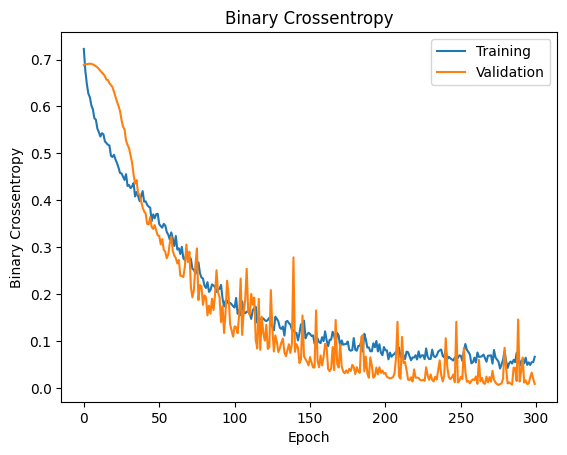

In [85]:
for i in ['Accuracy', "AUC", "Binary Crossentropy"]:
  plt.title(i)
  plt.ylabel(i)
  if i == "Binary Crossentropy":
    low = 'loss'
  else:
    low = i.lower()
  plt.plot(history2.history[low], label="Training")
  plt.plot(history2.history['val_' + low], label="Validation")
  plt.xlabel("Epoch")
  plt.legend()
  plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1.0


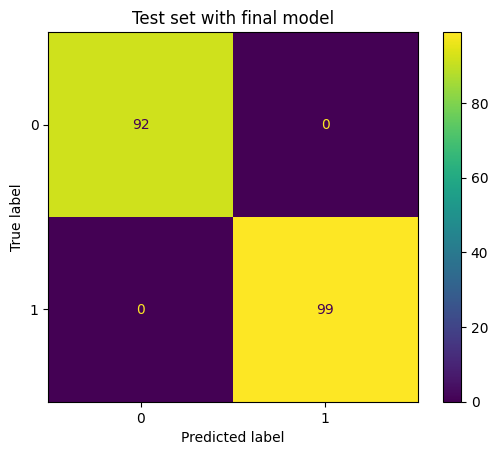

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1.0


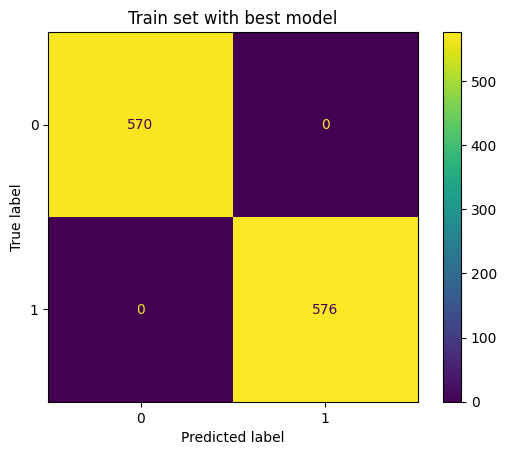

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1.0


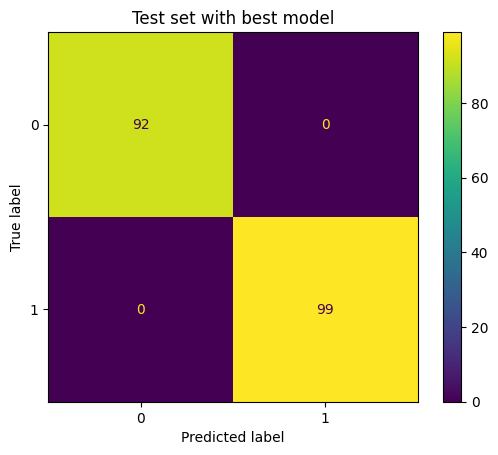

In [86]:
# MSE for testing
y_pred = model2.predict(X_test) >= 0.5
print(np.sum(y_pred == ty_test) / len(y_pred))
a = ConfusionMatrixDisplay(confusion_matrix(ty_test, y_pred))
a.plot()
plt.title("Test set with final model")
plt.show()

# MSE for training
pred_2 = load_model("best_model2.keras").predict(X_train) >= 0.5
print(np.sum(pred_2 == ty_train) / len(pred_2))
a = ConfusionMatrixDisplay(confusion_matrix(ty_train, pred_2))
a.plot()
plt.title("Train set with best model")
plt.show()

# prediction of best model (testing)
pred_2 = load_model("best_model2.keras").predict(X_test) >= 0.5
print(np.sum(pred_2 == ty_test) / len(pred_2))
a = ConfusionMatrixDisplay(confusion_matrix(ty_test, pred_2))
a.plot()
plt.title("Test set with best model")
plt.show()

In [57]:
pred_2

array([False,  True,  True, False, False, False, False, False, False,
       False, False,  True, False,  True,  True,  True,  True,  True,
       False, False,  True,  True, False, False, False,  True, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True, False,  True,  True, False,
        True,  True,  True, False,  True, False,  True,  True, False,
       False, False,  True, False, False, False, False,  True,  True,
       False,  True, False,  True, False, False, False,  True, False,
       False,  True,  True, False,  True, False,  True,  True,  True,
        True, False, False, False,  True,  True,  True,  True,  True,
       False, False, False, False,  True,  True, False,  True, False,
       False, False,  True, False, False, False,  True,  True,  True,
       False, False,  True, False,  True, False, False, False,  True,
        True, False,

In [58]:
ty_test

array([[False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [